<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/adm0/exposure_by_th_adm0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt

In [49]:

data_dir = '/content/drive/MyDrive/CCRI_results_misc'
misc_dir = '/content/drive/MyDrive/misc'
# Step 1: Read the CSV file containing the ccri_score
ccri_score = pd.read_csv(os.path.join(data_dir,'p1_p2_avg_ccri.csv'))
unicef_region  = pd.read_csv(os.path.join(misc_dir,'UNICEF_PROG_REG_GLOBAL.csv'))
ccri_score = ccri_score.merge(unicef_region, left_on='ISO3', right_on='ISO3Code', how='left')

# Step 2: Read the CSV file for child population data
child_pop_sum = pd.read_csv(os.path.join(data_dir,'child_pop_sum_adm0.csv'))

# Step 3: Group the child population data by 'ISO3' and sum the values
child_pop_sum_grouped = child_pop_sum.groupby('ISO3', as_index=False)['child_population'].sum()

# Step 4: Merge the ccri_score DataFrame with the grouped child population data on 'ISO3'
ccri_score_pop = ccri_score.merge(child_pop_sum_grouped, on='ISO3', how='left')



# Step 5: Extract the ccri values and calculate statistics
ccri_values = ccri_score_pop['P1_P2_geometric_avg'].values

# Calculate mean, std, and percentiles
mean_ccri = np.nanmean(ccri_values)
std_ccri = np.nanstd(ccri_values)

mean_plus_1sd_ccri = mean_ccri + std_ccri
mean_plus_2sd_ccri = mean_ccri + 2 * std_ccri

percentile_75_ccri = np.nanpercentile(ccri_values, 75)
percentile_90_ccri = np.nanpercentile(ccri_values, 90)
percentile_95_ccri = np.nanpercentile(ccri_values, 95)
percentile_99_ccri = np.nanpercentile(ccri_values, 99)

# Step 6: Identify ISO3 values with higher CCRI scores than each threshold
threshold_groups = {
    'percentile_75': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > percentile_75_ccri],
    'percentile_90': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > percentile_90_ccri],
    'percentile_95': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > percentile_95_ccri],
    'percentile_99': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > percentile_99_ccri],
}

# Group by Region and sum child population for each threshold
region_child_pop_by_threshold = {
    key: df.groupby('Region', as_index=False)['child_population'].sum()
    for key, df in threshold_groups.items()
}


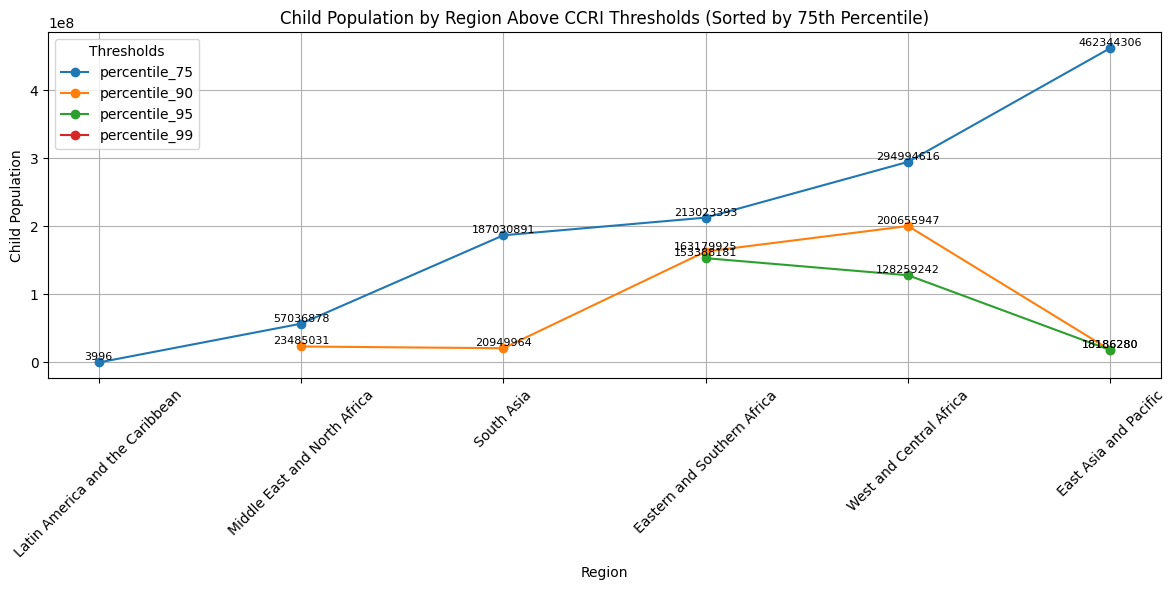

In [51]:
# Sort regions by child population in the 'percentile_75' threshold
sorted_regions = region_child_pop_by_threshold['percentile_75'].sort_values(
    'child_population', ascending=True
)['Region'].tolist()

# Replot with labels showing child population at each point (safely handling NaNs)
fig, ax = plt.subplots(figsize=(12, 6))

for key, df in region_child_pop_by_threshold.items():
    df_sorted = df.set_index('Region').reindex(sorted_regions).reset_index()
    ax.plot(df_sorted['Region'], df_sorted['child_population'], marker='o', label=key)

    # Add text labels for each point
    for i, row in df_sorted.iterrows():
        value = row['child_population']
        if pd.notna(value):
            ax.text(row['Region'], value + 2, f"{int(value)}",
                    ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_title("Child Population by Region Above CCRI Thresholds (Sorted by 75th Percentile)")
ax.set_ylabel("Child Population")
ax.set_xlabel("Region")
ax.legend(title="Thresholds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

plt.show()




In [54]:
df_75 = threshold_groups['percentile_75'][['Country', 'Region', 'child_population','P1_P2_geometric_avg']].copy()


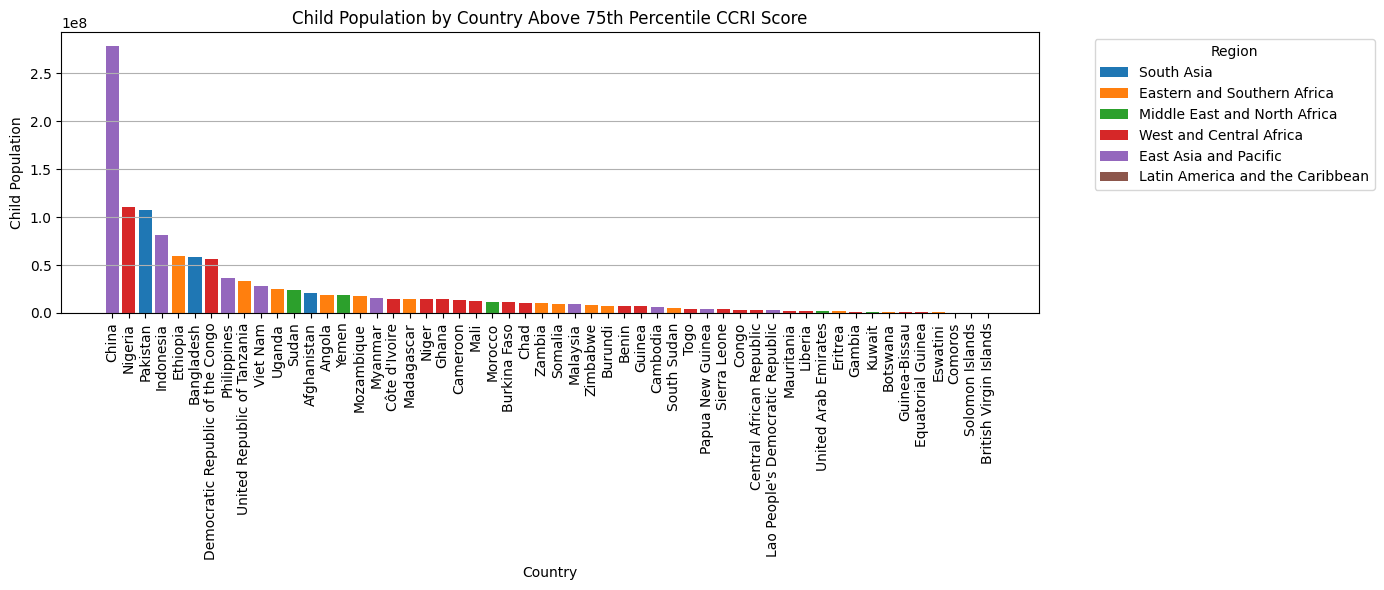

In [55]:
import matplotlib.colors as mcolors

# Use a more aesthetically pleasing color palette
fancy_palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
unique_regions = df_75['Region'].dropna().unique()

# Assign distinct fancy colors to regions
fancy_region_colors = {
    region: fancy_palette[i % len(fancy_palette)] for i, region in enumerate(unique_regions)
}

# Apply to the cleaned DataFrame
df_75_sorted = df_75.sort_values(by='child_population', ascending=False)
df_75_cleaned = df_75_sorted.dropna(subset=['Country']).copy()
df_75_cleaned['Country'] = df_75_cleaned['Country'].astype(str)
colors = df_75_cleaned['Region'].map(fancy_region_colors).fillna('gray')

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(df_75_cleaned['Country'], df_75_cleaned['child_population'], color=colors)


# Updated legend with fancy colors
legend_elements = [Patch(facecolor=color, label=region) for region, color in fancy_region_colors.items()]
ax.legend(handles=legend_elements, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Child Population by Country Above 75th Percentile CCRI Score")
ax.set_ylabel("Child Population")
ax.set_xlabel("Country")
ax.grid(True, axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


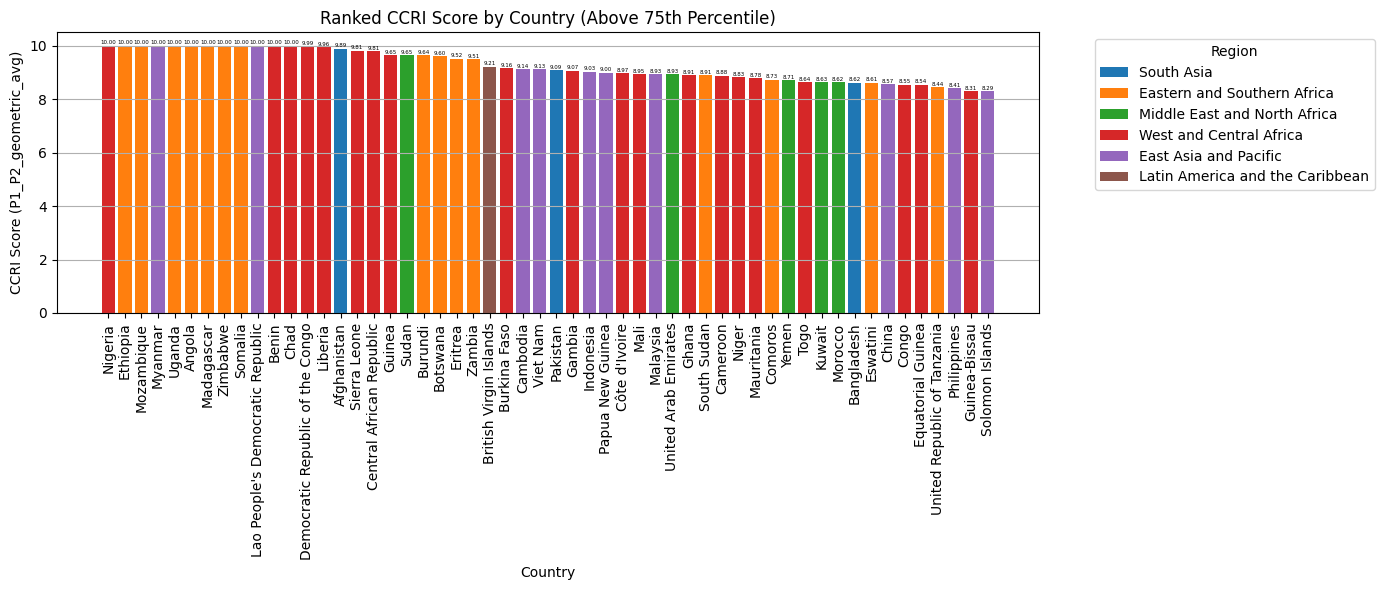

In [57]:
# Sort by CCRI score
df_ccri_sorted = df_75_cleaned.sort_values(by='P1_P2_geometric_avg', ascending=False)

# Map colors again for consistency
colors = df_ccri_sorted['Region'].map(fancy_region_colors).fillna('gray')

# Plot ranked by CCRI Score
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(df_ccri_sorted['Country'], df_ccri_sorted['P1_P2_geometric_avg'], color=colors)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
            ha='center', va='bottom', fontsize=4)

# Updated legend
legend_elements = [Patch(facecolor=color, label=region) for region, color in fancy_region_colors.items()]
ax.legend(handles=legend_elements, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Ranked CCRI Score by Country (Above 75th Percentile)")
ax.set_ylabel("CCRI Score (P1_P2_geometric_avg)")
ax.set_xlabel("Country")
ax.grid(True, axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
